# Abell 1656: the Coma Cluster of Galaxies __ Simple Spectral Access Protocol (SSA)

Stefania Amodeo¹, Thomas Boch¹, Caroline Bot¹, Giulia Iafrate², Katharina A. Lutz¹, Manon Marchand¹, Massimo Ramella², and Jenny G.Sorce³⁴⁵

1. Université de Strasbourg, CNRS, Observatoire Astronomique de Strasbourg, UMR 7550, F-67000, Strasbourg, France
2. INAF - Osservatorio Astronomico di Trieste
3. Univ. Lille, CNRS, Centrale Lille, UMR 9189 CRIStAL, F-59000 Lille, France
4. Université Paris-Saclay, CNRS, Institut d'Astrophysique Spatiale, 91405, Orsay, France
5. Leibniz-Institut für Astrophysik (AIP), An der Sternwarte 16, D-14482 Potsdam, Germany


The original form of this tutorial authored by Massimo Ramella & Giulia Iafrate can be found on the [EURO-VO tutorials page](http://www.euro-vo.org/?q=science/scientific-tutorials). The version here is an adaptation into a jupyter notebook by the Strasbourg astronomical Data Center (CDS) team. 

***

## Introduction

The Coma Cluster is an ensemble of over 1000 galaxies that takes its name from the constellation Coma Berenices. 

The goals of this notebook tutorial are to:
 1. examine the Coma cluster of galaxies (Abell 1656) using services and data from the virtual observatory within a jupyter notebook. This allows a quick evaluation of the mean redshift and velocity dispersion of the cluster. Both measurements are important to study the evolution of galaxy clusters. To do so we use redshifts and photometry (Petrosian r magnitude) from the Sloan Digital Sky Survey ([SDSS](https://www.sdss.org/)) and then add redshifts from the Cluster And Infall Region Nearby Survey ([CAIRNS](https://iopscience.iop.org/article/10.1086/378599)) (Rines et al. 2003). This improves the completeness of the redshift sample,
 2. research the Mikulski Archive for Space Telescopes ([MAST](https://archive.stsci.edu/)) for Hubble Space Telescope (HST) spectra in the region of the Coma cluster,
 3. download a spectrum from MAST and do a quick analysis of the redshift of the emission lines in the spectrum. 

In [1]:
# Astronomy tools
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import vstack

# Access astronomical databases
import pyvo
from astroquery.simbad import Simbad
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch

# Sky visualization
from ipyaladin import Aladin

# For plots
import matplotlib.pyplot as plt
import seaborn as sns

# Data handling
import numpy as np
import specutils.analysis as spec_ana
from scipy.optimize import curve_fit
from specutils import SpectralRegion, Spectrum1D

## Step #1: Exploration of the Coma cluster

### Display the region of Abell 1656 in Aladin lite

[![Aladin](https://custom-icon-badges.demolab.com/badge/Aladin-gray.svg?logo=aladin&logoColor=purple&logoWidth=20)](https://aladin.cds.unistra.fr/aladin.gml "https://aladin.cds.unistra.fr/aladin.gml")

We start by displaying the Coma Cluster in an Aladin Lite widget. We will display DSS2 color images (`survey='P/DSS2/color'`) centered on Abell 1656 (`target='A1656'`) and set the field of view to $0.7^\circ$ (`fov=0.7`). 
At this distance, this field of view corresponds to approximately 1Mpc: this is large enough to look at the cluster. 

If you are using Jupyter lab you can open a second python3 notebook. On this new notebook click the "Python 3" button in the top-right corner of this notebook to switch kernel. A new window will pop up and you can then select this notebook (i.e. "Abel1656...") as a kernel. This will link the two notebooks such that they see the same variables. You may use the second notebook to look at Aladin Lite widget while doing the analysis in this notebook.

In [2]:
aladin = Aladin(target="A1656", fov=0.7, survey="P/DSS2/color")
aladin

Aladin(fov=0.7, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

You can already see galaxies composing the cluster, and a few stars, like for example the bright [HD112887 star](https://simbad.cds.unistra.fr/simbad/sim-coo?Coord=12+59+32.92000000000+%2B28+03+56.7300000000&Radius=10&Radius.unit=arcmin&submit=submit+query) (click for a surprise Simbad query). But there is more! As with any Aladin Lite implementation, you can interact with this widget. 
 
 - to zoom in and out, place your mouse pointer on the image and scroll,
 - you can right-click on a point to grab it and center the reticule on it, 
 - with ![layers](Data/images/ipyaladin_layer.png) you can select other image surveys,
 - if you would like to look at another target, you can use the search field ![search](Data/images/ipyaladin_search.png) to get there. 

We can also interact with the variable `aladin`. If, for example, after zooming in and out, you wanted to set the FoV (field of view) again to $0.7^\circ$, run:

In [3]:
aladin.fov = 0.7

and look back up ... or call the variable `aladin` again to pop a new widget window. You'll remark that the field of view and reticule position are synchronized, but not the survey if you change if manually with ![layers](Data/images/ipyaladin_layer.png). It can allow the exploration of the same region in two different wavelengths. 

In [4]:
aladin

Aladin(fov=0.7, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

### Load the SDSS catalog and select galaxies

[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

In this section, we will access the SDSS DR12 catalog from the [VizieR](https://vizier.cds.unistra.fr/) catalog service. We will download all entries that are located within 40arcmin of the center of the cluster A1656. We start by querying VizieR for all catalogs that match the term `SDSS DR12`.

Since this query takes a few seconds, we will store its results in the variable `catalog_list_sdss` for further analysis.

In [5]:
catalog_list_sdss = Vizier.find_catalogs("SDSS DR12")
catalog_list_sdss

OrderedDict([('V/147', </>),
             ('J/ApJ/807/178', </>),
             ('J/ApJ/835/161', </>),
             ('J/ApJ/888/85', </>),
             ('J/ApJ/901/93', </>),
             ('J/ApJS/225/23', </>),
             ('J/ApJS/228/9', </>),
             ('J/ApJS/229/39', </>),
             ('J/A+A/583/A86', </>),
             ('J/A+A/596/A14', </>),
             ('J/PASP/130/H4203', </>),
             ('J/MNRAS/452/4153', </>),
             ('J/MNRAS/455/3413', </>),
             ('J/MNRAS/469/2102', </>)])

The output is not easily readable. Let's inspect a bit more this object.

In [6]:
print(f"The catalog is returned and stored in a {type(catalog_list_sdss)}")

The catalog is returned and stored in a <class 'collections.OrderedDict'>


To know how to deal with this ordered dictionary, we look at its first entry and list the methods applicable to the associated value.

In [7]:
# just selecting the value of the first item in the dictionnary
first_entry_value = catalog_list_sdss[next(iter(catalog_list_sdss))]
# the dir() function is built in python > 3. It lists all available methods for an object
# it is a really useful tool when discovering a new python library
print(dir(first_entry_value))

['ID', '_ID', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_add_coosys', '_add_definitions', '_add_group', '_add_info', '_add_link', '_add_param', '_add_resource', '_add_table', '_add_timesys', '_add_unknown_tag', '_attr_list', '_config', '_coordinate_systems', '_description', '_element_name', '_extra_attributes', '_groups', '_ignore_add', '_infos', '_links', '_name', '_params', '_pos', '_resources', '_tables', '_time_systems', '_type', '_utype', '_utype_in_v1_2', 'coordinate_systems', 'description', 'extra_attributes', 'groups', 'infos', 'iter_coosys', 'iter_fields_and_params', 'iter_info', 'iter_tables', 'iter_timesys', 'links', 'name', 'params', 'parse', 'resources', 'tables', 'time_syste

Among the possible methods, we chose to print the `description`, but feel free to explore the catalog list in any other way :)

In [8]:
# Let's display a list of the catalogs' names and descriptions
for key, catalog in catalog_list_sdss.items():
    print(key, ": ", catalog.description)

V/147 :  The SDSS Photometric Catalogue, Release 12 (Alam+, 2015)
J/ApJ/807/178 :  Newly rich galaxy clusters identified in SDSS-DR12 (Wen+, 2015)
J/ApJ/835/161 :  A cosmic void catalog of SDSS DR12 BOSS galaxies (Mao+, 2017)
J/ApJ/888/85 :  Ghostly strong Lya absorbers in SDSS DR12 (Fathivavsari, 2020)
J/ApJ/901/93 :  Model atmosphere analysis of hot WDs from SDSS DR12 (Bedard+, 2020)
J/ApJS/225/23 :  Compact groups of galaxies from SDSS-DR12 (MLCG) (Sohn+, 2016)
J/ApJS/228/9 :  Physical parameters of ~300000 SDSS-DR12 QSOs (Kozlowski, 2017)
J/ApJS/229/39 :  Narrow line Seyfert 1 galaxies from SDSS-DR12 (Rakshit+, 2017)
J/A+A/583/A86 :  DB white dwarfs in SDSS DR10 and DR12 (Koester+, 2015)
J/A+A/596/A14 :  Group catalogues of the local universe (Saulder+, 2016)
J/PASP/130/H4203 :  Newly spectroscopically confirmed DB white dwarfs (Kong+, 2018)
J/MNRAS/452/4153 :  SDSS DR12 QSOs [OIII] doublet (Albareti+, 2015)
J/MNRAS/455/3413 :  New white dwarf and subdwarf stars in SDSS DR12 (Keple

In this list, the first item is the complete SDSS catalog, while the others are sub-catalogs produced from the full one that often adds information. These other catalogs are published in astronomical journals (ex: ApJ stands for the Astrophysical Journal) and are curated, formated, and included in the Vizier catalogs list by a team of documentalists and astronomes in the CDS. 

We are interested in data from the main SDSS DR12 photometric catalog: "The SDSS Photometric Catalogue, Release 12 (Alam+, 2015)". We query its content in 10arcmin around the center of the Coma Cluster.

In [9]:
results_test_sdss = Vizier.query_region("A1656", radius="0d10m0s", catalog="V/147")
print(results_test_sdss)

TableList with 1 tables:
	'0:V/147/sdss12' with 23 column(s) and 50 row(s) 


As you see, there is only one table in our resulting list of tables. Moreover, this table has only 50 rows, an extremely small number! It is actually due to the default limit in the number of rows of the `Vizier.query_region` function. For now, we will use this small table to see what columns could be interesting. We will query without a row limit once we know what we need. This is a general good practice and allows to avoid unneccesary manipulation of huge tables.

To access the unique table in the list, we select the first table of the catalogue with `results_test_sdss[0]`. And we can again print the list of available methods for this object:

In [10]:
print(dir(results_test_sdss[0]))

['Column', 'ColumnClass', 'MaskedColumn', 'Row', 'TableColumns', 'TableFormatter', '__array__', '__bytes__', '__class__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_base_repr_', '_check_names_dtype', '_column_class', '_convert_col_for_table', '_convert_data_to_col', '_convert_string_dtype', '_copy_indices', '_first_colname', '_get_col_cls_for_table', '_init_from_cols', '_init_from_dict', '_init_from_list', '_init_from_list_of_dicts', '_init_from_ndarray', '_init_indices', '_ipython_key_completions_', '_is_list_or_tuple_of_str', '_is_mixin_for_table', '_make_index_row_display_table', '_ma

Let's see its columns:

In [11]:
print(results_test_sdss[0].colnames)

['RA_ICRS', 'DE_ICRS', 'mode', 'q_mode', 'class', 'SDSS12', 'm_SDSS12', '_tab1_18', 'Q', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp', 'zph', 'e_zph', '__zph_']


But since the names don't mean a lot by themselves, let's also look at another method, the `info` one that gives more detailed information about each column. If these descriptions are still not clear, you can also have a look directly at the [SDSS DR12 webpage](https://www.sdss.org/dr12/).

In [12]:
print(results_test_sdss[0].info)

<Table length=50>
  name    dtype  unit  format                                                                   description                                                                  n_bad
-------- ------- ---- -------- --------------------------------------------------------------------------------------------------------------------------------------------- -----
 RA_ICRS float64  deg {:10.6f}                                                                                  Right Ascension of the object (ICRS) at Epoch="ObsDate" (ra)     0
 DE_ICRS float64  deg {:10.6f}                                                                                     Declination of the object (ICRS) at Epoch="ObsDate" (dec)     0
    mode   uint8                                                                                  [1/2] 1: primary (469,053,874 sources), 2: secondary (324,960,094 sources)     0
  q_mode    str1                                                                       

For our current goal, we will need the coordinates (`RA_ICRS` and `DE_ICRS`), r-band magnitudes (`rmag`),and redshifts (`zsp`) of the galaxies in the Coma cluster. Hence, we only keep these columns. 

SDSS furthermore provides information on the type of source (galaxies correspond to `class` = 3, see the `info` output above) so we'll want to keep these. 

Additionally, and this information is specific to the SDSS survey (see [their website](https://www.sdss.org/dr12/help/glossary/)), some objects are observed more than once because of the overlaps between plates. To avoid these duplicates, we select only the primary observation of each object (corresponding to `mode` = 1). 

A first way of obtaining unique records (`mode` = 1) for the galaxies (`class` = 3) would be to apply masks on the precedent test table:

In [13]:
masked_sdss = results_test_sdss[0]
masked_sdss = masked_sdss[(masked_sdss["mode"] == 1) & (masked_sdss["class"] == 3)]
# note the important double [] here
masked_sdss[["RA_ICRS", "DE_ICRS", "rmag", "zsp"]].pprint()

 RA_ICRS    DE_ICRS    rmag    zsp   
   deg        deg      mag           
---------- ---------- ------ --------
194.898322  27.824928 25.666       --
194.866758  27.836941 18.788       --
194.880537  27.835338 21.533       --
194.882785  27.830918 20.872       --
194.893763  27.823545 19.719       --
194.893826  27.829963 23.613       --
194.868513  27.834005 22.168       --
194.883249  27.839735 22.061       --
194.872526  27.850157 14.436  0.02264
194.860237  27.856882 17.548       --
       ...        ...    ...      ...
194.832127  27.880659 21.086       --
194.818875  27.873814 22.804       --
194.821035  27.872558 22.729       --
194.826019  27.882583 22.282       --
194.839031  27.866565 21.038  0.51578
194.837992  27.862871 22.196       --
194.836993  27.865032 24.383       --
194.838772  27.871596 18.756       --
194.844106  27.868562 21.546       --
194.844697  27.869371 22.301       --
Length = 33 rows


But here is a second option using a specialized instance of the Vizier class in which we will lift the restriction on the number of rows.

To know how to do so, always use the magic help in jupyter notebooks:

In [14]:
help(Vizier)

Help on VizierClass in module astroquery.vizier.core object:

class VizierClass(astroquery.query.BaseQuery)
 |  VizierClass(columns=['*'], column_filters={}, catalog=None, keywords=None, ucd='', timeout=60, vizier_server='vizier.u-strasbg.fr', row_limit=50)
 |  
 |  Method resolution order:
 |      VizierClass
 |      astroquery.query.BaseQuery
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, columns=['*'], column_filters={}, catalog=None, keywords=None, ucd='', timeout=60, vizier_server='vizier.u-strasbg.fr', row_limit=50)
 |      Parameters
 |      ----------
 |      columns : list
 |          List of strings
 |      column_filters : dict
 |      catalog : str or None
 |      keywords : str or None
 |      ucd : string
 |          "Unified Content Description" column descriptions.  Specifying
 |          these will select only catalogs that have columns matching the
 |          column descriptions defined on the Vizier web pages.
 |          See http://v

Where we can directly read that we should give the `columns` names as a list, the `column_filters` as a dictionary, and the `row_limit` as an int. It is even specified that `row_limit` = -1 puts no limit on the number of rows. So let us do this:

In [15]:
vizier_instance = Vizier(
    columns=["RA_ICRS", "DE_ICRS", "rmag", "zsp"],
    column_filters={"class": "==3", "mode": "==1"},
    row_limit=-1,
)

Now that we have prepared everything, we can query VizieR for all galaxies, which are primary sources and within 40arcmin of the center of the Coma cluster. Note that VizieR knows that `A1656` is the center of the Coma cluster. If you wanted to search at some other place in the sky, you could also give coordinates (in the form of Astropy's `SkyCoord`) instead of `'A1656'`.

In [16]:
results_coma_sdss = vizier_instance.query_region(
    "A1656",
    radius="0d40m0s",
    catalog="V/147",
)
print(results_coma_sdss)

TableList with 1 tables:
	'0:V/147/sdss12' with 4 column(s) and 23770 row(s) 


As you can see, the result of our query includes data from one catalog for 23770 objects (*i.e.* the table has 23770 rows). The output from this query is again a list of Astropy Table objects. We assign the table to the variable `sdss` and work with this from here on. 

In [17]:
sdss = results_coma_sdss[0]
sdss

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
195.208103,27.362136,22.487,--
195.211488,27.368132,21.056,--
195.234870,27.366292,20.244,--
195.217532,27.366354,22.695,--
195.220894,27.375381,22.440,--
195.221253,27.372262,22.266,--
195.240371,27.366851,21.962,--
195.242662,27.369376,22.027,--


By navigating this table, you'll remark that very few entries have a spectroscopic redshift `zsp`. Thus we will complete the results later with information from another table. But we'll first ensure the validity of the entries here. 

### Identify the brightest sources as stars contaminating the sample

<img src=Data/images/logos/aladin.svg alt="aladin's logo" style="height:100px; display: inline-block;"/>
We have already restricted our sample to sources that are classified as galaxies (`class` = 3). However, for very bright sources, stars might be confused with galaxies. To test this and exclude any contamination from stars, we now take a closer look at the brightest sources. To do so we select sources brighter than 11.5 mag in r-band (`rmag < 11.5`) and check with the Aladin widget what these sources look like.

In [18]:
aladin

Aladin(fov=0.7, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'ov…

In [19]:
limit_magnitude = 11.5
stars = sdss[sdss["rmag"] < limit_magnitude]
aladin.add_table(stars["RA_ICRS", "DE_ICRS"])
print(
    f"Our sample contains {len(stars)} really bright sources with a magnitude below {limit_magnitude}.",
)
aladin.fov = 9

Our sample contains 11 really bright sources with a magnitude below 11.5.


With `aladin.add_table(stars)`, we have added symbols to the Aladin Lite widget at the location of the brightest sources (*i.e.* stars). You will be able to find all the brightest sources. By looking at each source you will find that these are indeed stars. Feel free to change the limit magnitude or other parameters to see if you can find better filters, this one is pretty rudimentary.

You can choose to hide or show the symbols for the table entries in the ![layer](Data/images/ipyaladin_layer.png) options, the tableappears as `catalog`

### Build a subset of galaxies with photometry and redshift in SDSS

Now on to exploring the galaxies in our sample. 
We again build a subset, this time for all sources fainter than 11.5mag (to leave out the stars identified in the section above) but brighter than 17.77mag, which is the [completeness limit of the SDSS spectroscopic sample](https://www.sdss.org/dr12/algorithms/legacy_target_selection/). 

In [20]:
sdss_sample = sdss[(sdss["rmag"] > 11.5) & (sdss["rmag"] < 17.77)]
sdss_sample

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
195.275800,27.397826,15.842,0.02706
194.905631,27.336047,16.011,0.02326
195.121706,27.333216,16.015,1.33693
195.074226,27.387516,15.367,0.03678
195.074954,27.385966,17.653,--
195.219915,27.384368,17.561,--
195.208010,27.405782,13.926,0.02198
195.053832,27.396513,17.553,0.29843


### Improve the completeness with other sources of redshifts in Vizier


[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

As you can see in the table above, not all galaxies in our zsp17 sample have redshift measurements (some rows have '--' in the 'zsp' column, i.e. they are masked). So to improve the completeness of our sample we will now use Vizier to search for redshifts in the Rines et al (2003) catalog. First, find all catalogs that match the search terms 'redshifts Rines 2003':

In [21]:
catalog_list_rines = Vizier.find_catalogs("Rines 2003")
for k, v in catalog_list_rines.items():
    print(k, ": ", v.description)

J/ApJ/700/331 :  Light curves of type Ia supernovae (CfA3) (Hicken+, 2009)
J/ApJ/757/22 :  Strong and weak lensing analysis of A2261 (Coe+, 2012)
J/ApJ/767/15 :  Hectospec Cluster Survey (HeCS) (Rines+, 2013)
J/ApJ/783/52 :  Redshifts in the field of A383 (Geller+, 2014)
J/ApJ/797/106 :  Redshifts in nine galaxy cluster fields (Hwang+, 2014)
J/ApJ/819/63 :  Hectospec survey of SZ clusters (HeCS-SZ) (Rines+, 2016)
J/ApJ/855/100 :  The HectoMAP cluster survey. II. X-ray clusters (Sohn+, 2018)
J/ApJ/856/172 :  The HectoMAP cluster survey. I. (Sohn+, 2018)
J/ApJ/862/172 :  HeCS-red: Hectospec surveys of redMaPPer clusters (Rines+, 2018)
J/ApJ/871/129 :  A redshift catalog of the galaxy cluster A2029 (Sohn+, 2019)
J/ApJ/891/129 :  The HeCS-omnibus catalog: SDSS & MMT sp. obs. (Sohn+, 2020)
J/ApJS/229/20 :  MMT/Hectospec redshift survey for Abell 2029 (Sohn+, 2017)
J/AJ/120/2338 :  Abell 576 redshifts (Rines+, 2000)
J/AJ/124/1266 :  Redshift survey around Abell 2199 (Rines+, 2002)
J/AJ/126/2

Among these, we find the 'J/AJ/126/2152' catalog:  Cluster And Infall Region Nearby Survey. I (Rines+, 2003): the one we'd like to read.

So again, let's take a quick look at this catalog. 

In [22]:
results_test_rines = Vizier.query_region(
    "A1656",
    radius="0d10m0s",
    catalog="J/AJ/126/2152",
)
print(results_test_rines)

TableList with 2 tables:
	'0:J/AJ/126/2152/clusters' with 10 column(s) and 1 row(s) 
	'1:J/AJ/126/2152/galaxies' with 6 column(s) and 50 row(s) 


In [23]:
results_test_rines[0]

Cluster,n_Cluster,RAJ2000,DEJ2000,cz,sigmap_3s_,sigmap_ca_,LX,TX,R
,,'h:m:s','d:m:s',km / s,km / s,km / s,1e+36 W,keV,
str5,str1,str10,str9,int32,int16,int16,float32,float32,uint8
A1656,g,12 59 31.9,+27 54 10,6973,1042,957,18.0,8.0,2


In [24]:
results_test_rines[1]

RAJ2000,DEJ2000,cz,e_cz,r_cz,Cluster
'h:m:s','d:m:s',km / s,km / s,,
str11,str11,int32,int32,uint8,str5
12 59 03.85,+27 57 32.6,6978,6,2,A1656
12 59 05.83,+27 59 49.5,7699,27,1,A1656
12 59 09.43,+28 02 27.0,7220,31,2,A1656
12 59 11.51,+28 00 33.1,6942,30,2,A1656
12 59 13.00,+27 58 39.0,6747,64,1,A1656
12 59 13.83,+28 04 36.0,7805,28,1,A1656
12 59 14.36,+27 55 58.2,58669,75,2,A1656
12 59 14.61,+27 53 43.9,6450,21,2,A1656


In [25]:
results_test_rines[1].info()

<Table length=50>
  name  dtype   unit                        description                      
------- ----- ------- -------------------------------------------------------
RAJ2000 str11 'h:m:s'                         Hour of right ascension (J2000)
DEJ2000 str11 'd:m:s'                           Degree of declination (J2000)
     cz int32  km / s                                                Redshift
   e_cz int32  km / s ? Error in cz [NULL integer written as an empty string]
   r_cz uint8                                    [1/2] Redshift reference (1)
Cluster  str5                                   Abell cluster name, or "Both"


[![Xmatch](https://custom-icon-badges.demolab.com/badge/Xmatch-gray.svg?logo=xmatch&logoColor=blue&logoWidth=20)](http://cdsxmatch.u-strasbg.fr/ "http://cdsxmatch.u-strasbg.fr/")

After inspecting the result of the test query, we see that the first table describes the cluster as an ensemble. The second one describes individual galaxies in the cluster. The later, named `1:J/AJ/126/2152/galaxies` contains the information we want.

To see which of the galaxies in the `1:J/AJ/126/2152/galaxies` table could fill in the gaps in our SDSS table, we first isolate the galaxies without redshifts in `zsp17`. Then we spatially crossmatch the two tables using the [CDS XMatch service](http://cdsxmatch.u-strasbg.fr/xmatch) via the `astroquery.XMatch.query` module. 

In [26]:
# mask zsp17 for entries with a nan value in the zsp column
sdss_sample_without_zsp = sdss_sample[np.isnan(sdss_sample["zsp"])]
sdss_sample_with_zsp = sdss_sample[~np.isnan(sdss_sample["zsp"])]
sdss_sample_without_zsp

RA_ICRS,DE_ICRS,rmag,zsp
deg,deg,mag,
float64,float64,float32,float64
195.074954,27.385966,17.653,--
195.219915,27.384368,17.561,--
195.152531,27.575845,17.521,--
194.563614,27.464697,17.736,--
194.482062,27.490099,17.555,--
194.437268,27.576120,17.760,--
194.724123,27.388636,17.521,--
194.689551,27.446954,17.474,--


In [27]:
xmatch_sdss_rines = XMatch.query(
    cat1=sdss_sample_without_zsp,
    cat2="vizier:J/AJ/126/2152/galaxies",
    max_distance=5 * u.arcsec,
    colRA1="RA_ICRS",
    colDec1="DE_ICRS",
)
xmatch_sdss_rines

angDist,RA_ICRS,DE_ICRS,rmag,zsp,_RAJ2000,_DEJ2000,RAJ2000,DEJ2000,cz,e_cz,r_cz,Cluster
float64,float64,float64,float64,int64,float64,float64,str11,str11,int64,int64,int64,str5
4.756129,195.074954,27.385966,17.653,--,195.0743333,27.3871667,13 00 17.84,+27 23 13.8,11114,9,2,A1656
0.268487,194.563614,27.464697,17.736,--,194.5636667,27.4646389,12 58 15.28,+27 27 52.7,7625,27,2,A1656
0.089868,194.724123,27.388636,17.521,--,194.724125,27.3886111,12 58 53.79,+27 23 19.0,7654,50,2,A1656
0.284257,194.860237,27.856882,17.548,--,194.8601667,27.8568333,12 59 26.44,+27 51 24.6,5007,75,2,A1656
1.346011,194.7349,27.803568,17.533,--,194.7349167,27.8031944,12 58 56.38,+27 48 11.5,7864,64,2,A1656
0.271796,195.213773,27.689156,17.643,--,195.21375,27.6890833,13 00 51.30,+27 41 20.7,8184,75,2,A1656
0.993647,195.466883,27.636194,17.703,--,195.46675,27.6359444,13 01 52.02,+27 38 09.4,17437,27,2,A1656
0.503127,195.118402,27.761221,17.495,--,195.118375,27.7610833,13 00 28.41,+27 45 39.9,6835,75,2,A1656
2.31869,195.442461,27.9578,15.158,--,195.441875,27.9574167,13 01 46.05,+27 57 26.7,4706,13,2,A1656


### Build the final catalog including the Rines et al. (2003) redshifts

The resulting table of the cross-match above contains 25 rows, so we have found recession velocity ('cz') measurements for 25 galaxies. Now let's add these data to the zsp17_with table.

In [28]:
# converts redshift into velocity
c = 2.998e5  # km/s speed of light
sdss_sample_with_zsp["cz"] = sdss_sample_with_zsp["zsp"] * c
# from the cross math result, only keep columns that are in sdss_sample_with_zsp
to_complete = xmatch_sdss_rines[sdss_sample_with_zsp.colnames]
# put together the two tables
complete_sample = vstack([sdss_sample_with_zsp, to_complete])
# don't forget to set the unit of the newly created column
complete_sample["cz"].unit = u.km / u.s
complete_sample

RA_ICRS,DE_ICRS,rmag,zsp,cz
deg,deg,mag,,km / s
float64,float64,float64,float64,float64
195.275800,27.397826,15.842,0.02706,8112.588000000001
194.905631,27.336047,16.011,0.02326,6973.348
195.121706,27.333216,16.015,1.33693,400811.614
195.074226,27.387516,15.367,0.03678,11026.644
195.208010,27.405782,13.926,0.02198,6589.604
195.053832,27.396513,17.553,0.29843,89469.314
195.046668,27.460084,17.625,0.02282,6841.436
195.046028,27.480776,17.338,0.15689,47035.622


Now we have a table with all galaxies that either have a redshift measurement in SDSS or a velocity value obtained by (Rines *et al.* 2003).

Overall, this sample within 40arcmin of the center of the Coma cluster contains 514 galaxies.

Before we start the analysis of the data, let's look at the galaxies in the sample by loading the table into the Aladin Lite widget. They will appear as `catalog_1` and with a different color than the bright stars we added before. 

In [29]:
aladin.add_table(complete_sample)

scroll up to the aladin widget to see the table

### Determine velocity distribution, cluster average velocity, and velocity dispersion

Based on the 514 galaxies, we can now analyze the recession velocity and velocity dispersion of the Abell 1656 galaxy cluster. First, we visualize the recession velocity distribution of the entire sample:

In [30]:
# pandas is the most used library for tables in python and offers more
# compatibilities with plottling or analysis libraries. Be extremely
# careful though because the conversion loses the information about the
# column unit.
df_complete_sample = complete_sample.to_pandas()

In [31]:
type(df_complete_sample)

pandas.core.frame.DataFrame

We called the converted table with a "df" at the beginning of its name because this object type is a DataFrame (df).

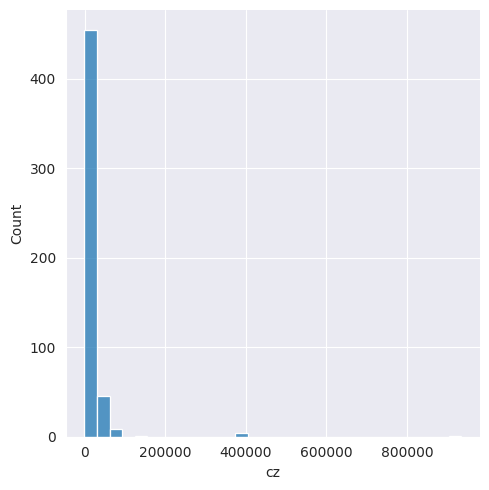

In [32]:
sns.set_style("darkgrid")
# bins is the number of bars in the histogram
sns.displot(data=df_complete_sample, x="cz", bins=30);

Note how there is a large range of recession velocities in our sample. We are only interested in the range of recession velocities of the Coma cluster. These are around the peak at low velocities. Thus, we restrict our sample to a subset `df_Coma` to recession velocities between 3000 and 11000 km/s:

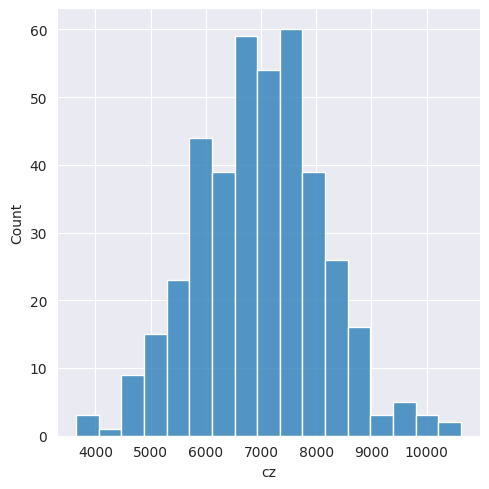

In [33]:
df_Coma = df_complete_sample[
    (df_complete_sample["cz"] > 3000.0) & (df_complete_sample["cz"] < 11000.0)
]  # here we apply a mask with two conditions to the dataframe based on criteria about the column "cz"

sns.displot(data=df_Coma, x="cz");

This subset corresponds to galaxies in the vicinity of the cluster (both spatially and in recession velocity). Let's calculate the mean recession velocity of the cluster and its velocity dispersion:

In [34]:
print(
    f"The mean velocity in Coma is {df_Coma['cz'].mean()} km/s."
    f" Its velocity dispersion (i.e. standard deviation) is {df_Coma['cz'].std()} km/s.",
)

The mean velocity in Coma is 6974.036149625936 km/s. Its velocity dispersion (i.e. standard deviation) is 1139.6493233485016 km/s.


It is in agreement with more refined analyses (e.g. [Sohn et al. 2017, ApJS, 229, 20](https://iopscience.iop.org/article/10.3847/1538-4365/aa653e)).

When looking back at the query results for the Rines et al. (2003) catalog, you can check again the table that describes the full cluster. The mean recession velocity `cz` = 6973km/s and dispersion `sigmap_3s_` = 1042km/s for the Coma cluster are is also in good agreement with our results. 

In [35]:
results_test_rines[0]

Cluster,n_Cluster,RAJ2000,DEJ2000,cz,sigmap_3s_,sigmap_ca_,LX,TX,R
,,'h:m:s','d:m:s',km / s,km / s,km / s,1e+36 W,keV,
str5,str1,str10,str9,int32,int16,int16,float32,float32,uint8
A1656,g,12 59 31.9,+27 54 10,6973,1042,957,18.0,8.0,2


## Search for Hubble Space Telescope (HST) spectra from the Coma Cluster

We now want to find out whether there are HST spectra available for the galaxies that had neither a redshift in SDSS nor a velocity in the catalog Rines *et al.* (2003).

We use the [Simple Spectral Access (SSA) protocol from the IVOA](http://www.ivoa.net/documents/SSA/) to query the Mikulski Archive for Space Telescopes (MAST). Once again, we look at an area of 40arcmin around the center of the Coma Cluster. 

In [36]:
mast_ssa_service = pyvo.dal.SSAService(
    "https://archive.stsci.edu/ssap/search2.php?id=HST&",
)
diameter = u.Quantity(2 * 40.0, unit="arcmin")
position = SkyCoord.from_name("A1656")
mast_hst_results = mast_ssa_service.search(pos=position, diameter=diameter)
mast_hst_results

<Table length=21>
   ra_obs    dec_obs           coord_targ         ...   fluxcal    ang_sep
    deg        deg                deg             ...                     
  float64    float64           float64[2]         ...    object    float64
----------- ---------- -------------------------- ... ------------ -------
195.2537375 28.3289472 195.2537375 .. 28.32894722 ... UNCALIBRATED  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ... UNCALIBRATED  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.2537375 28.3289472 195.2537375 .. 28.32894722 ...     ABSOLUTE  26.271
195.253

Note that `mast_hst_results` is not a list of tables as we had for `astroquery` queries. This time, we get a pyvo `resultset`. Thus the methods to handle the `resultset` are slightly different but can still be printed out with the `dir()` function which is generic in python. Let's find out which columns are available:

In [37]:
print("--- Available methods: ", dir(mast_hst_results))
print("--- Name of columns: ", mast_hst_results.fieldnames)

--- Available methods:  ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adhocservices', '_findinfos', '_findresultsresource', '_findresultstable', '_findstatus', '_findstatusinfo', '_fldnames', '_from_result_url', '_infos', '_resultstable', '_session', '_status', '_url', '_votable', 'broadcast_samp', 'cursor', 'fielddescs', 'fieldname_with_ucd', 'fieldname_with_utype', 'fieldnames', 'from_result_url', 'get_adhocservice_by_id', 'get_adhocservice_by_ivoid', 'getcolumn', 'getdesc', 'getrecord', 'getvalue', 'iter_adhocservices', 'iter_datalinks', 'queryurl', 'resultstable', 'status', 'table', 'to_table', 'votable']
--- Name of columns:  ('ra_obs', 'dec_obs', 

In [38]:
for observation in mast_hst_results:
    print(observation["object"])

WAVE
QSO-1258+285
QSO-1258+285
QSO-1258+285
QSO-1258+285
WAVE
QSO-1258+285
QSO-1258+285
QSO-1258+285
QSO-1258+285
WAVE
QSO-1258+285
QSO-1258+285
QSO-1258+285
QSO-1258+285
WAVE
QSO-1258+285
QSO-1258+285
QSO-1258+285
QSO-1258+285
1257+2840



[![Simbad](https://custom-icon-badges.demolab.com/badge/Simbad-gray.svg?logo=simbad&logoColor=lightblue&logoWidth=20)](https://simbad.u-strasbg.fr/simbad/ "https://simbad.u-strasbg.fr/simbad/")

Often Quasars are further away than the Coma cluster, so let's check quickly on Simbad whether this source is interesting for further analysis. Usually a Simbad query would only return information on the object's identifier and coordinates. We are, however, also interested in its redshift, so we first create a customised Simbad query (as we did above for VizieR, for more details see [here](https://astroquery.readthedocs.io/en/latest/simbad/simbad.html#customizing-the-default-settings)) and then submit the query.

In [39]:
custom_Simbad = Simbad()
custom_Simbad.add_votable_fields("z_value")
qso_table = custom_Simbad.query_object("QSO 1258+285")
qso_table

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,Z_VALUE,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,float64,int32
QSO B1258+2835,13 01 00.8675,+28 19 44.741,14,14,0.049,0.040,90,A,O,2020yCat.1350....0G,1.3610200,1


As you can see in the column before last, the Quasar is at a redshift of 1.36. This is far beyond the Coma Cluster. Therefore, we focus on the source '1257+2840' for now. 1257+2840 is the last source in the list: we assign it to a new variable (`interesting_observation`). Then we exploit the functionalities of `resultset` to find out where the data is and what kind of file it is. 

In [40]:
interesting_observation = mast_hst_results[-1]
observation_url = interesting_observation.getdataurl()
print(observation_url)

http://archive.stsci.edu/pub/vospectra/fos2/y1hi1402t_vop.fits


### A quick analysis of the discovered spectrum

With the previous step, we obtained a link to a fits file which we can download and open with `astropy`.  

In [41]:
spectrum_fits = fits.open(observation_url)
spectrum_fits

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7ff72707fbb0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7ff726a2b790>]

we see that `spectrum_fits` is a list of two astropy HDU (Header Data Unit) objects. Let's look at the second one (with index 1) 

In [42]:
spectrum_fits[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.4b           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                24768 /Number of bytes per row                         
NAXIS2  =                    1 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                    3 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** Column names ***                                                   
COMMENT                                                                         
TTYPE1  = 'WAVE    '           /                                                
TTYPE2  = 'FLUX    '        

From the fits information and the header, it appears that we have three columns (listed in one axis though): 
- wavelength in Angstrom, 
- flux and flux error in $\mathrm{erg \cdot cm}^{-2} \mathrm{s}^{-1} \mathrm{\r{A}}^{-1}$.

For a first quick look we can plot the spectrum:

Text(0, 0.5, 'Flux ($\\mathrm{erg \\cdot cm}^{-2} \\mathrm{s}^{-1} \\mathrm{\\AA}^{-1}$)')

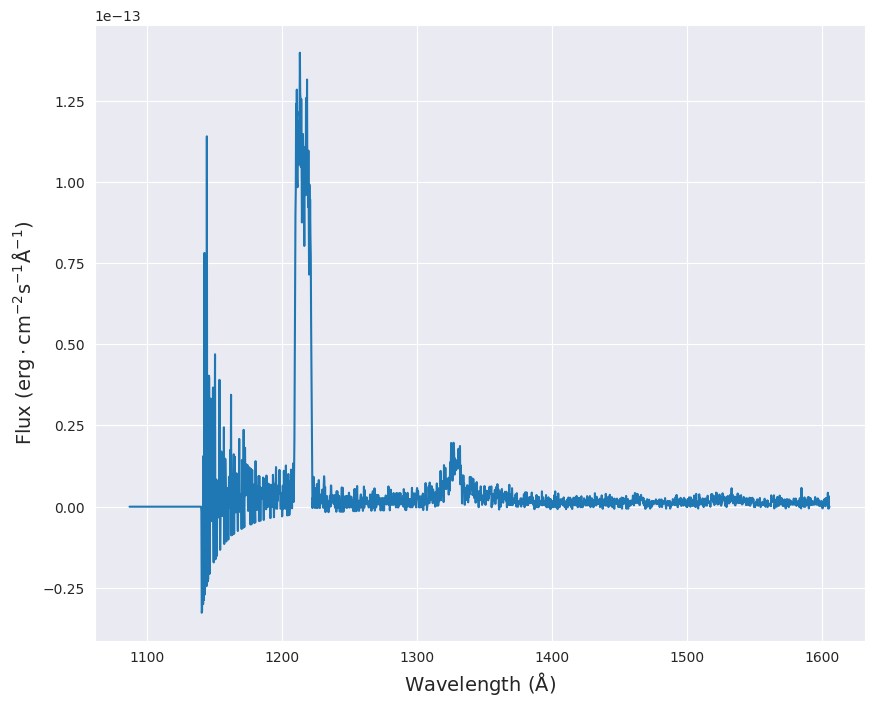

In [43]:
fig = plt.figure(figsize=(10.0, 8.0))
ax = fig.add_axes([0.17, 0.17, 0.77, 0.77])
ax.plot(spectrum_fits[1].data[0][0], spectrum_fits[1].data[0][1])
ax.set_xlabel(r"Wavelength ($\mathrm{\AA}$)", fontsize=14)
ax.set_ylabel(
    r"Flux ($\mathrm{erg \cdot cm}^{-2} \mathrm{s}^{-1} \mathrm{\AA}^{-1}$)",
    fontsize=14,
)

It is a spectrum in the ultraviolet with two visible emission lines, one around $1220\mathrm{\r{A}}$ and one around $1330\mathrm{\r{A}}$. We know that wavelength at rest of the Lyman $\alpha$ line is at $1216\mathrm{\r{A}}$. This spectrum might thus show Ly$\alpha$ (atomic hydrogen, HI) emission of the Milky Way (hardly redshifted) and a redshifted extragalactic source. 

To investigate this further, we use the `specutils` package. First, we define a 1D spectrum: the data format that `specutils` accepts. 

In [44]:
flux_unit = u.erg / u.cm**2 / u.s / u.Angstrom
spectrum = Spectrum1D(
    spectral_axis=spectrum_fits[1].data[0][0] * u.Angstrom,
    flux=spectrum_fits[1].data[0][1] * flux_unit,
)
spectrum

<Spectrum1D(flux=<Quantity [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           -5.2580507e-16,  0.0000000e+00,  0.0000000e+00] erg / (Angstrom cm2 s)>, spectral_axis=<SpectralAxis [1087.1409, 1087.3932, 1087.6455, ..., 1605.2651, 1605.5122, 1605.7592] Angstrom>)>

Now we can use `specutils_analysis` functions to analyze the spectrum. Let's find the centroid of the two lines.

In [45]:
# find the first peak, between 1200 and 1260 Angstrom
centroid_Milky_Way = spec_ana.centroid(
    spectrum,
    SpectralRegion(1200 * u.Angstrom, 1260 * u.Angstrom),
)
# find the second peak, between 1300 and 1370 Angstrom
centroid_second_peak = spec_ana.centroid(
    spectrum,
    SpectralRegion(1300 * u.Angstrom, 1370 * u.Angstrom),
)
print("The centroid of the first peak is located at: ", centroid_Milky_Way)
print("The centroid of the second peak is located at: ", centroid_second_peak)

The centroid of the first peak is located at:  1216.476806640625 Angstrom
The centroid of the second peak is located at:  1332.959228515625 Angstrom


Indeed the first peak is centered around the rest wavelength of the Ly$\alpha$ line. We may thus assume that this is the HI emission from the Milky Way in the foreground. Now assuming that the second line is also Ly$\alpha$ emission, let's calculate the redshift and recession velocity:

In [46]:
rest_Ly_alpha = 1216.0
redshift_z = (centroid_second_peak.value - rest_Ly_alpha) / rest_Ly_alpha
cz = redshift_z * c  # speed of light in km/s, defined before
print(
    f"The source has a redshift of {round(redshift_z, 3)}"
    f" and a recession velocity of {round(cz, 2)} km/s",
)

The source has a redshift of 0.096 and a recession velocity of 28835.84 km/s


Although this source is much closer than the Quasar, it is still further away than the Coma Cluster and thus not a member of the Cluster. 

An alternative to using `specutils` we can also use more generic python packages and fit the emission lines with simple Gaussians. Let's define the Gaussian:

In [47]:
def gauss(x, height, peak_position, sigma):
    """Gaussian 1d function.

    Parameters
    ----------
    x : numpy 1d array or a list
        list or array of wavelengths
    height : float
        multiplicative factor for the height of the gaussian function
    peak_position : float
        wavelength corresponding to the peak position
    sigma : float
        standard deviation that controlls with of the peak

    Returns
    -------
    numpy array
    """
    return height * np.exp(
        -((np.asarray(x) - peak_position) ** 2.0) / (2 * sigma**2.0),
    )

Next, we select the two parts of the spectrum where the emission lines are:

In [48]:
# separate wavelengths and fluxes in different objects
spectrum_wavelengths = spectrum_fits[1].data[0][0]
spectrum_flux = spectrum_fits[1].data[0][1]

# make a mask to select wavelengths between 1190 and 1240 Angstrom
mask_Milky_Way = np.where(
    (spectrum_wavelengths < 1240.0) & (spectrum_wavelengths > 1190),
)
wavelengths_Milky_Way = spectrum_wavelengths[mask_Milky_Way]
flux_Milky_Way = spectrum_flux[mask_Milky_Way]

# make a mask to select wavelengths between 1300 and 1380 Angstrom
mask_second_peak = np.where(
    (spectrum_wavelengths < 1380) & (spectrum_wavelengths > 1300),
)
wavelengths_second_peak = spectrum_wavelengths[mask_second_peak]
flux_second_peak = spectrum_flux[mask_second_peak]

The Gaussian fit is done with the `curve_fit` function of the `scipy.optimize` library.

In [49]:
popt_Milky_Way_line, pcov_Milky_Way_line = curve_fit(
    gauss,
    wavelengths_Milky_Way,
    flux_Milky_Way,
    p0=[1.25e-13, 1220.0, 10.0],
)
print(
    "The first peak, attributed to the Milky Way, has a",
    f" central wavelength of {round(popt_Milky_Way_line[1], 2)} ",
    f"+/- {round(np.sqrt(np.diag(pcov_Milky_Way_line))[1], 2)} km/s.",
)


popt_second_line, pcov_second_line = curve_fit(
    gauss,
    wavelengths_second_peak,
    flux_second_peak,
    p0=[0.2e-13, 1330.0, 10.0],
)
print(
    "The first peak for the other object has a",
    f"central wavelength of {round(popt_second_line[1], 2)}",
    f" +/- {round(np.sqrt(np.diag(pcov_second_line))[1], 2)} km/s.",
)

The first peak, attributed to the Milky Way, has a  central wavelength of 1215.38  +/- 0.13 km/s.
The first peak for the other object has a central wavelength of 1329.18  +/- 0.6 km/s.


These values are close to the results from the `specutils` package. 

To further check the fitting results, we plot the data, our model, and residuals:

Text(0, 0.5, 'Residual')

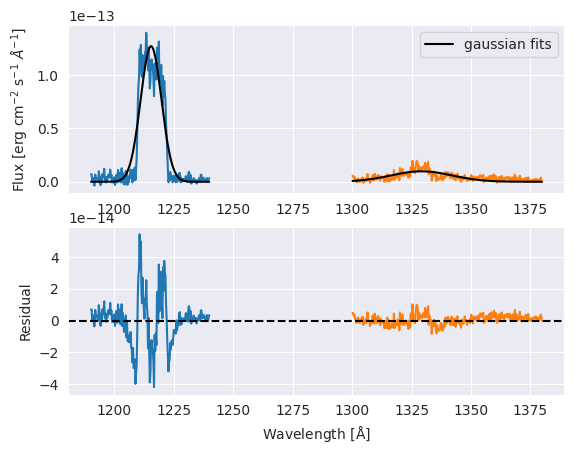

In [50]:
fig, axes = plt.subplots(2, 1)

# First plot is the data and models
sns.lineplot(x=wavelengths_Milky_Way, y=flux_Milky_Way, ax=axes[0])
sns.lineplot(
    x=wavelengths_Milky_Way,
    y=gauss(wavelengths_Milky_Way, *popt_Milky_Way_line),
    ls="-",
    color="k",
    ax=axes[0],
)
sns.lineplot(x=wavelengths_second_peak, y=flux_second_peak, ax=axes[0])
sns.lineplot(
    x=wavelengths_second_peak,
    y=gauss(wavelengths_second_peak, *popt_second_line),
    ls="-",
    color="k",
    ax=axes[0],
    label="gaussian fits",
)
axes[0].legend()
axes[0].set_ylabel(r"Flux [erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]")


# Second plot is the residuals = data - model
sns.lineplot(
    x=wavelengths_Milky_Way,
    y=flux_Milky_Way - gauss(wavelengths_Milky_Way, *popt_Milky_Way_line),
    ax=axes[1],
)
sns.lineplot(
    x=wavelengths_second_peak,
    y=flux_second_peak - gauss(wavelengths_second_peak, *popt_second_line),
    ax=axes[1],
)
axes[1].axhline(0, ls="--", c="k")
axes[1].set_xlabel(r"Wavelength [$\mathrm{\AA}$]")
axes[1].set_ylabel("Residual")

While fitting a Gaussian to the emission lines provides very good results with regard to the central wavelength (and thus redshift) of the observed objects, the residuals show that the emission from the Milky Way is much more complicated. 

In [51]:
# End of the tutorial
spectrum_fits.close()